# Spiked EBNM Example
 
This example introduces the Empirical Bayes Normal Means (EBNM) problem, which is a foundational building block for more complex models like matrix factorization.
 
**Purpose:**
- The EBNM problem involves estimating the true underlying effects from noisy observations, using flexible prior distributions.
- Solving the EBNM problem is much simpler than matrix factorization, as it deals with one-dimensional data rather than matrices.
- Understanding EBNM helps build intuition for how empirical Bayes methods work, which is essential before tackling the more challenging matrix factorization setting.
 
In this notebook, you will see how to set up and solve the EBNM problem, and how it relates to the broader goals of empirical Bayes matrix factorization.

In [1]:
import math

import matplotlib.pyplot as plt
import torch

from cebmf_torch.cebnm.emdn import emdn_posterior_means
from cebmf_torch.cebnm.spiked_emdn import spiked_emdn_posterior_means

In this example each latent variable $y$ is drawn from a uniform distribution

$$
y \sim U(-0.5, 2.5)
$$

we then have true $x_{\rm true}$ values as 

$$
x_{\rm true} \sim 
\begin{cases}
    \delta_0(y), & \text{if} \quad 0 < y < 0.5 \quad \text{or} \quad 1.5 < x < 2 \\
    N \left(0, \frac{1}{2} \sin(\pi y) \right), & \text{otherwise}
\end{cases}
$$

where $N(\mu, \sigma)$ is a normal distribution of mean $\mu$ and variance $\sigma^2$. We then draw our observed $x$ values to be

$$
x_{\rm obs} \sim N(x_{\rm true}, 1).
$$

We can write this problem as an EMDN-like problem, where the probability of $x_{\rm true}$ is given as a spiked EMDN prior

$$
P(x_{\rm true}) = \pi (y) \delta_0(x_{\rm true}) + \left( 1 - \pi(x_{\rm true}) \right) N(0, \sigma(y))
$$

where $\pi(y)$ is unity for $0 < y < 0.5$ and $1.5 < x < 2$ and zero otherwise, and $\sigma(y) = \frac{1}{2} \sin(\pi y)$.


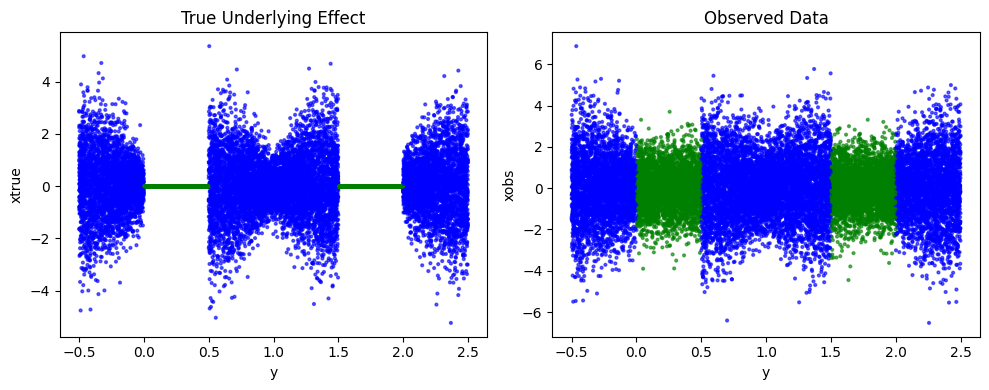

In [2]:
# Reproducibility
torch.manual_seed(1)

# Generate data in PyTorch
n_samples = 20_000
y = torch.empty(n_samples).uniform_(-0.5, 2.5)        # U(-0.5, 2.5)
X_covariate = y.view(-1, 1)

# masks for zero vs nonzero regions
mask_zero = ((y > 0) & (y < 0.5)) | ((y > 1.5) & (y < 2.0))

# noise level depends on x
noise_std = 0.5 + torch.abs(torch.sin(math.pi * y))

# xtrue: 0 in masked regions, Gaussian elsewhere with that std
xtrue = torch.where(mask_zero, torch.zeros_like(y), torch.randn_like(y) * noise_std)

# Observed data
sobs = torch.ones_like(y)  # known noise level
xobs = xtrue + torch.randn_like(y) * sobs
X = xobs.view(-1, 1)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
colors = torch.where(xtrue == 0, torch.tensor(0), torch.tensor(1))  # 0/1 labels
axs[0].scatter(y.cpu().numpy(), xtrue.cpu().numpy(),
            c=['green' if c == 0 else 'blue' for c in colors.tolist()],
            s=4, alpha=0.6)
axs[0].set_title('True Underlying Effect')
axs[0].set_xlabel('y')
axs[0].set_ylabel('xtrue')

axs[1].scatter(y.cpu().numpy(), xobs.cpu().numpy(),
               c=['green' if c == 0 else 'blue' for c in colors.tolist()],
               s=4, alpha=0.6)
axs[1].set_title('Observed Data')
axs[1].set_xlabel('y')
axs[1].set_ylabel('xobs')

plt.tight_layout()
plt.show()

## Fitting the model

In this example we compare two different models for the prior. We consider the EMDN (where we assume the prior is a sum of Gaussians) and the Spiked-EMDN prior (where we also add in a delta function to the Gaussian mixture). Here, we fit both of these

In [3]:
res =  emdn_posterior_means(
    X=X_covariate,
    betahat=xobs,
    sebetahat=sobs,
    n_epochs=200,
    n_layers=4,
    hidden_dim=64,
    n_gaussians=2,
)

[EMDN] Epoch 10/200, Loss: 1.7076
[EMDN] Epoch 20/200, Loss: 1.6965
[EMDN] Epoch 30/200, Loss: 1.6948
[EMDN] Epoch 40/200, Loss: 1.6941
[EMDN] Epoch 50/200, Loss: 1.6929
[EMDN] Epoch 60/200, Loss: 1.6894
[EMDN] Epoch 70/200, Loss: 1.6993
[EMDN] Epoch 80/200, Loss: 1.6996
[EMDN] Epoch 90/200, Loss: 1.7019
[EMDN] Epoch 100/200, Loss: 1.6976
[EMDN] Epoch 110/200, Loss: 1.6958
[EMDN] Epoch 120/200, Loss: 1.6932
[EMDN] Epoch 130/200, Loss: 1.6902
[EMDN] Epoch 140/200, Loss: 1.6924
[EMDN] Epoch 150/200, Loss: 1.6935
[EMDN] Epoch 160/200, Loss: 1.6877
[EMDN] Epoch 170/200, Loss: 1.6898
[EMDN] Epoch 180/200, Loss: 1.6940
[EMDN] Epoch 190/200, Loss: 1.6956
[EMDN] Epoch 200/200, Loss: 1.7031


In [4]:
res_spiked =  spiked_emdn_posterior_means(
    X=X_covariate,
    betahat=xobs,
    sebetahat=sobs,
    n_epochs=200,
    n_layers=4,
    hidden_dim=64,
    n_gaussians=2,
    penalty=1.,
)

[Spiked-EMDN] Epoch 10/200, Loss: 1.7011
[Spiked-EMDN] Epoch 20/200, Loss: 1.6938
[Spiked-EMDN] Epoch 30/200, Loss: 1.6964
[Spiked-EMDN] Epoch 40/200, Loss: 1.6937
[Spiked-EMDN] Epoch 50/200, Loss: 1.6964
[Spiked-EMDN] Epoch 60/200, Loss: 1.6953
[Spiked-EMDN] Epoch 70/200, Loss: 1.6918
[Spiked-EMDN] Epoch 80/200, Loss: 1.6930
[Spiked-EMDN] Epoch 90/200, Loss: 1.6941
[Spiked-EMDN] Epoch 100/200, Loss: 1.6922
[Spiked-EMDN] Epoch 110/200, Loss: 1.7042
[Spiked-EMDN] Epoch 120/200, Loss: 1.6980
[Spiked-EMDN] Epoch 130/200, Loss: 1.6915
[Spiked-EMDN] Epoch 140/200, Loss: 1.6935
[Spiked-EMDN] Epoch 150/200, Loss: 1.6930
[Spiked-EMDN] Epoch 160/200, Loss: 1.6991
[Spiked-EMDN] Epoch 170/200, Loss: 1.6885
[Spiked-EMDN] Epoch 180/200, Loss: 1.6927
[Spiked-EMDN] Epoch 190/200, Loss: 1.6945
[Spiked-EMDN] Epoch 200/200, Loss: 1.6912


## Results

Let us first look at how the posterior means compare to the true $x$ values and their observed counterparts. You immediately see that apply a EMDN approach massibvely reduces the difference betweent the predicted value and the truth, compared to just usinf $x_{\rm obs}$ as our prediction.

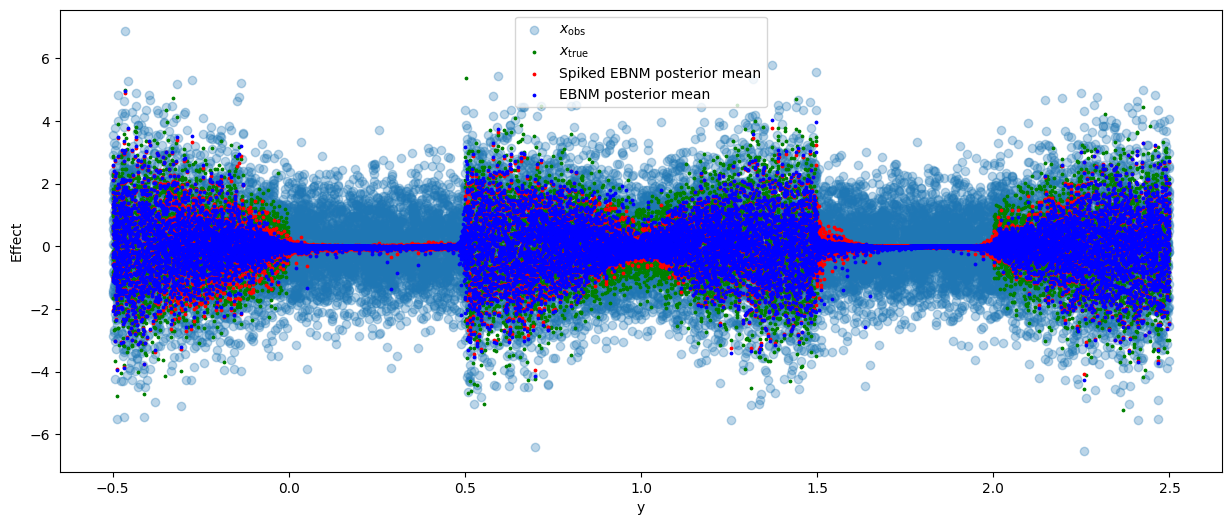

In [5]:
# Plot true vs posterior means
plt.figure(figsize=(15,6))
plt.scatter(y, xobs, alpha=0.3, label=r"$x_{\rm obs}$")
plt.scatter(y, xtrue, c="green", s=3, label=r"$x_{\rm true}$")
plt.scatter(y, res_spiked.post_mean, c="red", s=3, label="Spiked EBNM posterior mean")
plt.scatter(y, res.post_mean, c="blue", s=3, label="EBNM posterior mean")
plt.legend()
plt.xlabel("y")
plt.ylabel("Effect")
plt.show()

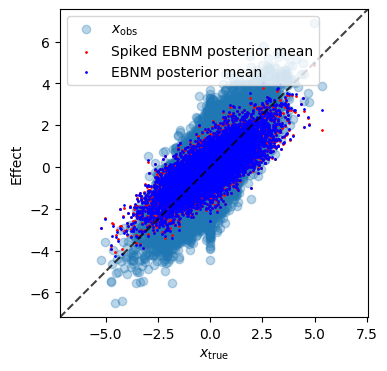

MSE of observed data: 1.0107
MSE of Spiked EBNM posterior means: 0.3720
MSE of EBNM posterior means: 0.3728


In [6]:
plt.figure(figsize=(4, 4))
plt.scatter(xtrue, xobs, alpha=0.3, label=r"$x_{\rm obs}$")
plt.scatter(xtrue, res_spiked.post_mean, c="red", s=1, label="Spiked EBNM posterior mean")
plt.scatter(xtrue, res.post_mean, c="blue", s=1, label="EBNM posterior mean")
plt.xlabel(r"$x_{\rm true}$")
plt.ylabel("Effect")
plt.legend(loc='upper left')
plt.gca().set_aspect('equal')
xlim = plt.xlim()
ylim = plt.ylim()
lims = [min(xlim[0], ylim[0]), max(xlim[1], ylim[1])]
plt.plot(lims, lims, 'k--', alpha=0.75)
plt.xlim(lims)
plt.ylim(lims)
plt.show()

mse_obs = torch.mean((xobs - xtrue)**2).item()
mse_ebnm = torch.mean((res.post_mean - xtrue)**2).item()
mse_spiked = torch.mean((res_spiked.post_mean - xtrue)**2).item()
print(f"MSE of observed data: {mse_obs:.4f}")
print(f"MSE of Spiked EBNM posterior means: {mse_spiked:.4f}")
print(f"MSE of EBNM posterior means: {mse_ebnm:.4f}")

## Comparing weights, means, and variances
 
In the plots below, we compare the inferred weights, means, and variances (covariances) of the EBNM and Spiked EBNM models to the ground truth.
 
- The **dashed lines** show the true values used to generate the data.
- The **solid lines** show the values inferred by the models.
 
You can see that the inferred parameters closely follow the true underlying structure. 
Where there are disagreements in the mean or covariance for a given component, this occurs when the weight
of that component is small, so any discrepancy has a small effect on the prior value.
This indicates that the models are able to recover the main features of the prior distribution from the observed data.

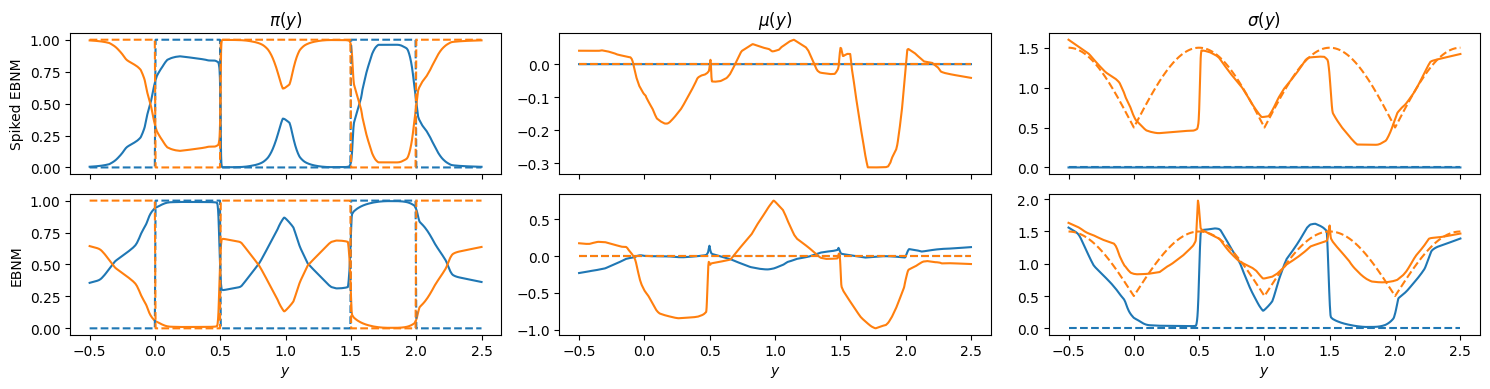

In [7]:
fig, axs = plt.subplots(2, 3, figsize=(15, 4), sharex=True)

m = torch.argsort(y)

for pi in res_spiked.pi_np.T:
    axs[0,0].plot(y[m], pi[m])

for pi in res.pi_np.T:
    axs[1,0].plot(y[m], pi[m])

for loc in res_spiked.location.T:
    axs[0,1].plot(y[m], loc[m])

for loc in res.location.T:
    axs[1,1].plot(y[m], loc[m])

for scale in res_spiked.scale.T:
    axs[0,2].plot(y[m], scale[m])

for scale in res.scale.T:
    axs[1,2].plot(y[m], scale[m])


# Make true weights, means, scales for comparison
yplot = torch.linspace(-0.5, 2.5, 500)
weights_0 = torch.where(((yplot > 0) & (yplot < 0.5)) | ((yplot > 1.5) & (yplot < 2.0)),
                        torch.tensor(1.0), torch.tensor(0.0))
weights_1 = 1 - weights_0
means_0 = torch.zeros_like(yplot)
means_1 = torch.zeros_like(yplot)
scales_0 = torch.zeros_like(yplot)

for ax in axs:
    ax[0].plot(yplot, weights_0, '--', color='C0')
    ax[0].plot(yplot, weights_1, '--', color='C1')
    ax[1].plot(yplot, means_0, '--', color='C0')
    ax[1].plot(yplot, means_1, '--', color='C1')
    ax[2].plot(yplot, scales_0, '--', color='C0')
    ax[2].plot(y[m], noise_std[m], '--', color='C1')

for ax in axs[1,:]:
    ax.set_xlabel(r'$y$')

axs[0,0].set_title(r'$\pi(y)$')
axs[0,1].set_title(r'$\mu(y)$')
axs[0,2].set_title(r'$\sigma(y)$')
axs[0,0].set_ylabel('Spiked EBNM')
axs[1,0].set_ylabel('EBNM')

fig.tight_layout()
